In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import FrEIA.framework as Ff
import FrEIA.modules as Fm

# from models import INN

In [3]:
def generate_toy_data(N=100000, uniform_range=50):
    mu = np.array([[0, 2], [-np.sqrt(3), -1], [np.sqrt(3), -1]])

    samples = np.concatenate(
        [np.random.multivariate_normal(m, 1 * np.eye(2), N) for m in mu]
    )

    labels = np.concatenate(
        [
            np.zeros(N),
            np.ones(N),
            2*np.ones(N),
        ]
    )

    return torch.tensor(samples, dtype=torch.float), torch.tensor(labels, dtype=torch.long)

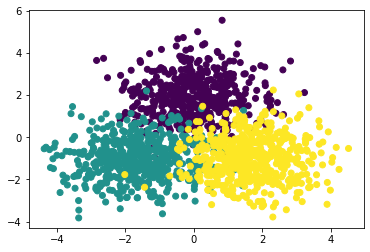

In [4]:
data, labels = generate_toy_data(500)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels)

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(2, 500),
            nn.ReLU(True),
            nn.Linear(500, 500),
            nn.ReLU(True),
            nn.Linear(500, 3),
#             nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        return self.layers(inputs)


def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 500), nn.ReLU(), nn.Linear(500, c_out))


def INN():
    nodes = [Ff.InputNode(2, name="input")]
    cond_node = Ff.ConditionNode(3)

    # Use a loop to produce a chain of coupling blocks
    for k in range(2):
        nodes.append(
            Ff.Node(
                nodes[-1],
                Fm.GLOWCouplingBlock,
                {"subnet_constructor": subnet_fc, "clamp": 2.0},
                name=f"coupling_{k}",
                conditions=cond_node
            )
        )

    nodes.append(Ff.OutputNode(nodes[-1], name="output"))
    nodes.append(cond_node)
    return Ff.ReversibleGraphNet(nodes)

In [6]:
inn = INN()
inn.cuda()
classifier = Classifier()
classifier.cuda()

optimizer = torch.optim.Adam(
        list(filter(lambda p: p.requires_grad, inn.parameters())),
        lr=1e-4,
        betas=[0.9, 0.999],
        weight_decay=1e-5,
    )


Node 'coupling_0' takes the following inputs:
	 Output #0 of node 'input' with dims (2,)
	 conditioned on node 'node' with dims (3,)

Node 'coupling_1' takes the following inputs:
	 Output #0 of node 'coupling_0' with dims (2,)
	 conditioned on node 'node' with dims (3,)

Node 'output' takes the following inputs:
	 Output #0 of node 'coupling_1' with dims (2,)



In [7]:
for n in range(1000):
    samples, labels = generate_toy_data(512)
    samples, labels = samples.to('cuda'), labels.to('cuda')
    cond_tensor = torch.zeros(labels.size(0), 3, device='cuda')
    cond_tensor.scatter_(1, labels.view(-1, 1), 1.0)
    
    optimizer.zero_grad()
    latent = inn(samples, cond_tensor)
    
    zz = torch.sum(latent ** 2, dim=1)
    jac = inn.log_jacobian(run_forward=False)

    neg_log_likeli = 0.5 * zz - jac
    nll = neg_log_likeli.mean()
    
    nll.backward()
    optimizer.step()
    
#     print(nll)

torch.Size([1500])


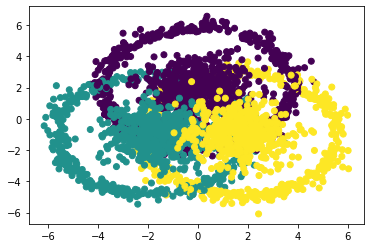

In [8]:
import scipy.stats as stats
with torch.no_grad():
    labels = torch.randint(3, (1500,), device='cuda')
    cond_tensor = torch.zeros(labels.size(0), 3, device='cuda')
    cond_tensor.scatter_(1, labels.view(-1, 1), 1.0)
    
#     samples = torch.randn(1500, 2, device='cuda')

    def b(log_n):
        return np.sqrt(2 * log_n) - (np.log(log_n) + np.log(4 * np.pi))/(2 * np.sqrt(2 * log_n))

    def a(log_n):
        return np.sqrt(2 * log_n)
    s = 3

    g = torch.distributions.gumbel.Gumbel(
            1.4+b((s*1.4 - 1.4)**2)*0.7, 1/a((s*1.4 - 1.4)**2)*0.7
        )

    r = g.sample((1500,)).to('cuda')
    print(r.shape)
    
    noise = torch.randn(1500, 2, device='cuda')
    noise /= torch.norm(noise, dim=1)[:, None]
    
    noise = noise * r[:, None]
    
    data = inn(noise, cond_tensor, rev=True).cpu()

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels.cpu())
data, labels = generate_toy_data(500)
plt.scatter(data[:, 0], data[:, 1], c=labels.cpu())

In [9]:
optimizer_c = torch.optim.Adam(
        classifier.parameters(),
        lr=1e-4,
        betas=[0.9, 0.999],
        weight_decay=1e-5,
    )

for n in range(1000):
    with torch.no_grad():
        labels = torch.randint(3, (1500,), device='cuda')

        cond_tensor = torch.zeros(labels.size(0), 3, device='cuda')
        cond_tensor.scatter_(1, labels.view(-1, 1), 1.0)
        
        t = torch.randn(1500, 2, device='cuda')
        samples = inn(t, cond_tensor, rev=True)
    
    optimizer_c.zero_grad()
    output = nn.functional.cross_entropy(classifier(samples), labels)
    output.backward()
    optimizer_c.step()
    
#     print(output)

torch.Size([10000, 2])


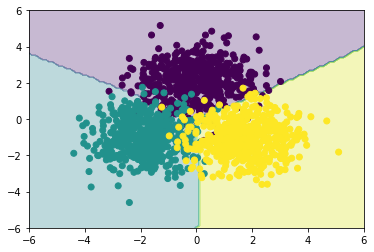

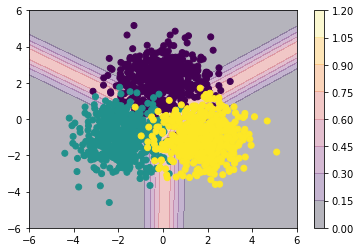

In [10]:
data, labels = generate_toy_data(500)

x = np.linspace(-6, 6, 100)

X, Y = np.meshgrid(x, x)
pos = torch.tensor(np.dstack((X, Y)), dtype=torch.float, device='cuda').reshape(-1, 2)
print(pos.shape)

Z1 = torch.argmax(torch.softmax(classifier(pos), dim=1), dim=1).detach().cpu().reshape(100, 100)
Z2 = -(torch.softmax(classifier(pos), dim=1) * torch.log_softmax(classifier(pos), dim=1)).sum(dim=1).reshape(100, 100).detach().cpu()

plt.figure()
plt.contourf(X, Y, Z1, alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], c=labels)

plt.figure()
a = plt.contourf(X, Y, Z2, alpha=0.3, cmap='inferno')
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.colorbar(a)

In [11]:
optimizer_c = torch.optim.Adam(
        classifier.parameters(),
        lr=1e-4,
        betas=[0.9, 0.999],
        weight_decay=1e-5,
    )

def b(log_n):
    return np.sqrt(2 * log_n) - (np.log(log_n) + np.log(4 * np.pi))/(2 * np.sqrt(2 * log_n))

def a(log_n):
    return np.sqrt(2 * log_n)
s = 3

g = torch.distributions.gumbel.Gumbel(
        1.4+b((s*1.4 - 1.4)**2)*0.7, 1/a((s*1.4 - 1.4)**2)*0.7
    )

uniform = torch.tensor([1/3, 1/3, 1/3], device='cuda', dtype=torch.float)

for n in range(1000):
    with torch.no_grad():
        labels = torch.randint(3, (1500,), device='cuda')

        cond_tensor = torch.zeros(labels.size(0), 3, device='cuda')
        cond_tensor.scatter_(1, labels.view(-1, 1), 1.0)
        
        t = torch.randn(1500, 2, device='cuda')
        samples = inn(t, cond_tensor, rev=True)
        
        r = g.sample((1500,)).to('cuda')

        noise = torch.randn(1500, 2, device='cuda')
        noise /= torch.norm(noise, dim=1)[:, None]

        noise = noise * r[:, None]
        
        osamples = inn(noise, cond_tensor, rev=True)
    
    optimizer_c.zero_grad()
    output = nn.functional.cross_entropy(classifier(samples), labels)
    kl = nn.functional.kl_div(
        torch.log_softmax(classifier(osamples), dim=1), uniform.reshape(1, 3).repeat(1500,1), reduction="batchmean"
    )
    
    loss = output + kl
    
    print(loss)
    loss.backward()
    optimizer_c.step()

tensor(5.6143, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5694, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.1192, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0110, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.7411, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5904, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4068, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.2936, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.1310, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.5801, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.4515, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.3600, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1272, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9922, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7875, device='cuda:0', grad_fn=<AddBack

torch.Size([10000, 2])


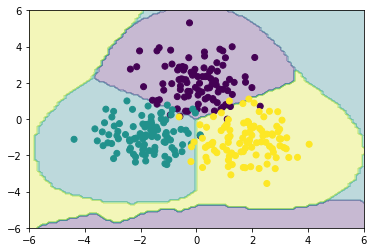

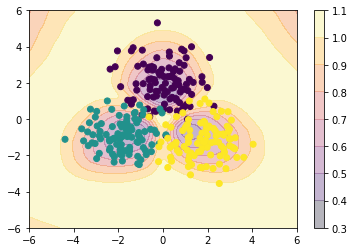

In [12]:
data, labels = generate_toy_data(100)

x = np.linspace(-6, 6, 100)

X, Y = np.meshgrid(x, x)
pos = torch.tensor(np.dstack((X, Y)), dtype=torch.float, device='cuda').reshape(-1, 2)
print(pos.shape)

Z1 = torch.argmax(torch.softmax(classifier(pos), dim=1), dim=1).detach().cpu().reshape(100, 100)
Z2 = -(torch.softmax(classifier(pos), dim=1) * torch.log_softmax(classifier(pos), dim=1)).sum(dim=1).reshape(100, 100).detach().cpu()

plt.figure()
plt.contourf(X, Y, Z1, alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], c=labels)

plt.figure()
a = plt.contourf(X, Y, Z2, alpha=0.3, cmap='inferno')
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.colorbar(a)